In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
import glob

In [3]:
files = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.pickle")
files_png = glob.glob("/mnt/data/yanzi/xiaomi_vacuum_as_data_collector/data_parsed_all/*.png")

In [4]:
def file_info(fname):
    parts = fname.split('/')[-1].split('_')
    date, time, dev, mac, _, pkt_type, _ = parts[:7]
    return date, time, dev, mac, pkt_type

In [6]:
import pickle
import numpy as np

In [7]:
import os
import sys
sys.path.append("/home/gomezp/advloc")
from models import create_model
from options.test_options import TestOptions
import torch
from data.rss_dataset import RSSDataset

In [8]:
# hack to avoid passing command-line arguments
sys.argv = ["--seed=666", "--gpu_ids=1",
            "--dataroot=''", "--name=rss_v3_8",
            "--model=rssmap2rssmap", "--input_nc=1",
            "--output_nc=1", "--norm=batch",
            "--dataset_mode=rss", "--num_threads=0",
            "--batch_size=1", "--netG=unet_64",
            "--verbose", "--no_flip", "--serial_batches"]
opt = TestOptions().parse()  # get test options
opt.display_id = -1 # do not use visdom; we will save plots ourselves

dataset = RSSDataset(opt)
model = create_model(opt)

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
             blocked_size: 0                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ''                            	[default: None]
             dataset_mode: rss                           	[default: aligned]
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             	[default: 0]
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 1                             	[default: 3]
                  isTrain: 

In [9]:
def test_single(A_path):
    with open(A_path, 'rb') as f:
        data_A = pickle.load(f)
    if data_A[1] is None:
        return
    
    # Extract ground truth from file
    date, time, dev, mac, pkt_type = file_info(A_path)
    map_A, x, y = data_A[0], *data_A[1]
    loc = np.array([x, y])
    
    # Prepare image as model input
    map_A = torch.tensor(dataset.normalize_data(map_A), dtype=torch.float32)
    map_A = map_A.view((1, map_A.size()[0], -1)).unsqueeze(0)

    tx_loc_np = (loc - 32.) / 64.
    # `normalize_loc` is not correct here: input coords are i [0,64] range, not [-5,5]
    #tx_loc_np = dataset.normalize_loc(loc)
    tx_loc = torch.tensor(tx_loc_np).float()
    tx_pwr_np = dataset.normalize_data(np.array([-34])) # hack; figure this out!
    tx_pwr = torch.tensor(tx_pwr_np).float()
    tx_loc_pwr = torch.cat((tx_loc, tx_pwr))

    # Pack input data
    data = {'A': map_A, 'B': map_A, 'A_paths': A_path, 'B_paths': A_path, 'tx_loc_pwr': tx_loc_pwr}
    
    realA = map_A.squeeze().numpy()
    
    # Forward and extract visuals
    model.set_input(data)
    model.test()
    visuals = model.get_current_visuals()
    visuals_np = {}
    for v in visuals:
        t = visuals[v]
        visuals_np[v] = t.cpu().float().squeeze().numpy()
    
    # Extract transmitter location from latent space
    task_tx_loc = model.latent[:2].cpu().float().squeeze().numpy()
    
    #return realA, realB, visuals_np, tx_loc_np, tx_pwr_np, task_tx_loc
    return realA, visuals_np, loc, task_tx_loc

In [37]:
def l2(x):
    from math import sqrt
    return sqrt(np.sum(x**2))

def test(epoch):
    print("Testing on epoch ", epoch)
    opt.epoch = epoch
    opt.load_iter = 0
    model.setup(opt)
    
    diffs = []
    for idx, fname in enumerate(files):
        res = test_single(fname)
        if res is None:
            continue

        _, _, loc, task_loc = res
        loc = (loc - 32.) / 64.
        diffs.append(l2(loc[::-1] - task_loc))

    diffs = np.array(diffs)
    return diffs.mean(), diffs.std(), diffs.min(), diffs.max()

In [40]:
# Testing...
# ---------------------
opt.epoch = 200
opt.load_iter = 0
model.setup(opt)
idx = -16

_, _, loc, task_loc = test_single(files[idx])
print((loc - 32.) / 64., "\n", task_loc)

from IPython.display import Image
Image(filename=files_png[idx]) 

## Localization statistics

In [38]:
%%time
%%capture
test_epoches = range(0,201,50)
diffs = []
for epoch in test_epoches:
    diffs.append(test(epoch))

CPU times: user 4.63 s, sys: 544 ms, total: 5.18 s
Wall time: 5.17 s


<ErrorbarContainer object of 3 artists>

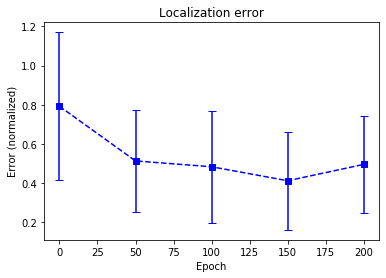

In [39]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Error (normalized)")
plt.title("Localization error")

test_epoches = list(test_epoches)
diffs = np.array(diffs)
means = diffs[:,0]
stds = diffs[:,1]
plt.errorbar(test_epoches, means, stds, marker="s", linestyle="--", color="blue", capsize=4)

In [13]:
import json
# Hack to serialize numpy arrays
class NPEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [14]:
json.dumps(diffs, cls=NPEncoder)

'[[0.8859884037315026, 0.413172029961274, 0.09907162515051349, 2.2960095753235854], [0.5849970874299217, 0.25685632675077896, 0.03260411700013247, 1.0894651461756089], [0.5685516132763204, 0.25572831445481464, 0.023943218398378402, 1.0338779536551512], [0.4840089685694672, 0.19525007929840463, 0.08395442024325561, 0.9278440355197553], [0.5348360558118271, 0.21691044734602744, 0.10269995392546438, 1.0772229753931317]]'